**Jevois Raspberry Pi ArUco Tracking**

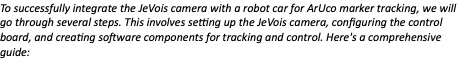

1. Setting Up the JeVois Camera Create a New Python Module in JeVois Inventor: Use the  Python script for ArUco marker detection. Ensure that the JeVois-Inventor is correctly installed, flashed with belenaEtcher and configured for the custom module.

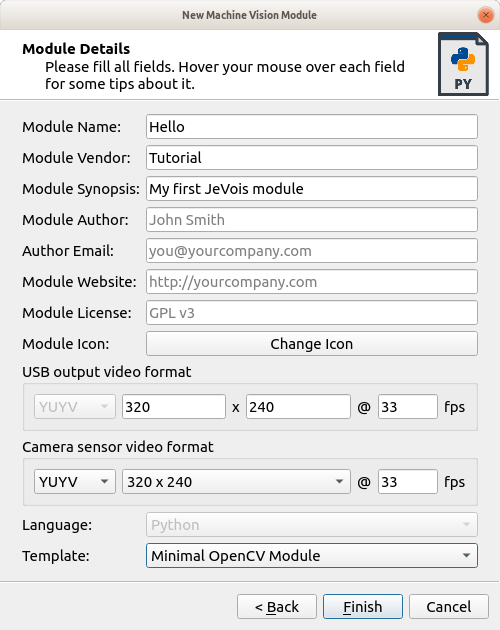

In [ ]:
import libjevois as jevois
import cv2
import numpy as np

class Hello:
    def __init__(self):
      self.dict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_4X4_50)
      self.params = cv2.aruco.DetectorParameters_create()
      self.timer = jevois.Timer('ArUco detection', 50, jevois.LOG_DEBUG)

    def process(self, inframe, outframe):
      img = inframe.getCvBGR()
      self.timer.start()
      grayimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      corners, ids, rej = cv2.aruco.detectMarkers(grayimg, self.dict, parameters = self.params)
      img = cv2.aruco.drawDetectedMarkers(img, corners, ids)

      if str(ids) != 'None':                                # new code
        for id in ids:                                      # new code
          jevois.sendSerial('Detected ArUco {}'.format(id)) # new code

      fps = self.timer.stop()
      cv2.putText(img, fps, (3,img.shape[0]-7), cv2.FONT_HERSHEY_SIMPLEX,
          0.4, (255,255,255), 1, cv2.LINE_AA)
      outframe.sendCv(img)


#NEW MODULE CODE 2 variant:

#import libjevois as jevois      --The libjevois module is specific to the JeVois machine vision environment
import cv2
import numpy as np

class PythonTest:
    def __init__(self):
        # Attempt to use a direct reference to the ArUco dictionary
        self.arucoDict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
        self.arucoParams = cv2.aruco.DetectorParameters_create()

    def process(self, inframe, outframe):
        img = inframe.getCvBGR()
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Detect ArUco markers
        corners, ids, rejected = cv2.aruco.detectMarkers(gray, self.arucoDict, parameters=self.arucoParams)

        # If markers are detected
        if ids is not None:
            for i in range(len(ids)):
                # Draw marker borders
                cv2.aruco.drawDetectedMarkers(img, corners, ids)

                # Display the marker ID
                c = corners[i][0]
                cv2.putText(img, str(ids[i][0]), (int(c[0][0]), int(c[0][1]) - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Convert the modified frame back to JeVois format and send it out
        outimg = jevois.convertCvBGRtoRawImage(img)
        outframe.send(outimg)

Install Required Libraries: If not already installed, ensure that OpenCV and libjevois are available in the Python-JeVois environment.

Test the Module: Load the module in JeVois Inventor and test with a live feed to ensure markers are correctly identified and printed in the console.

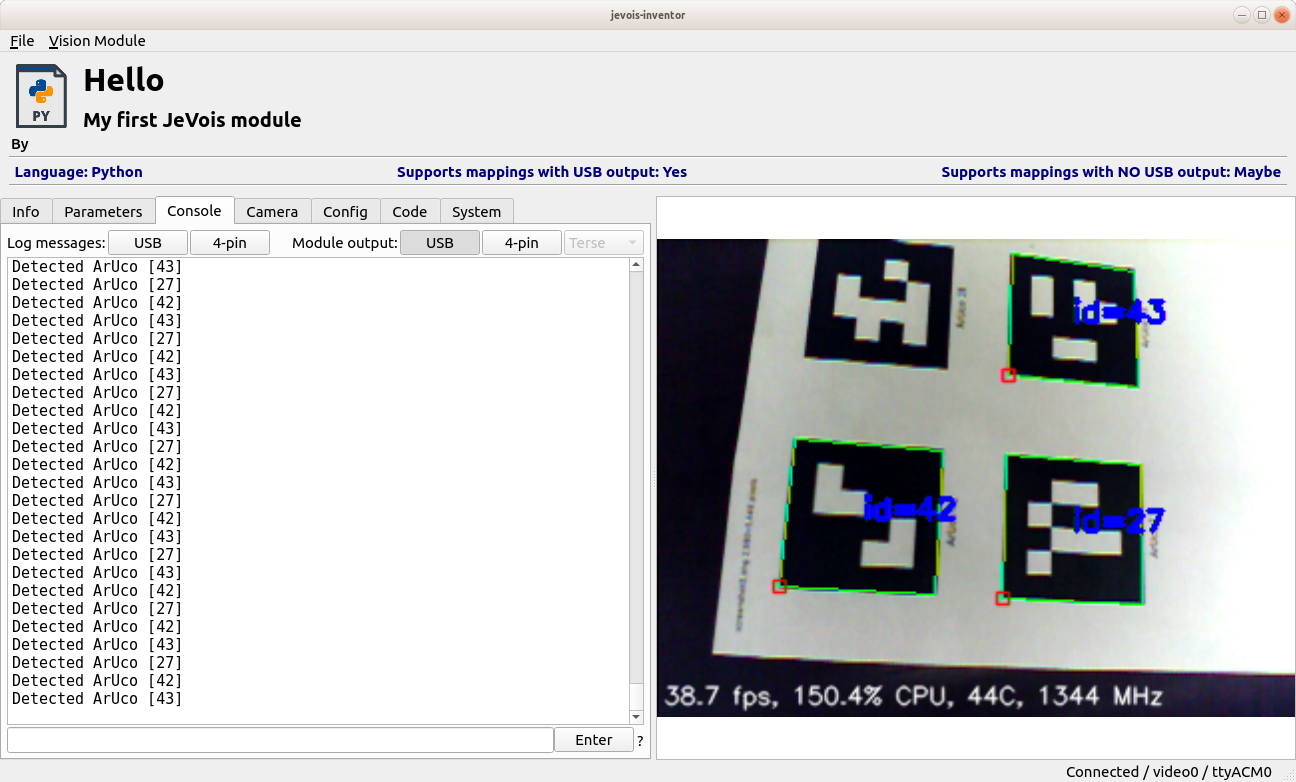

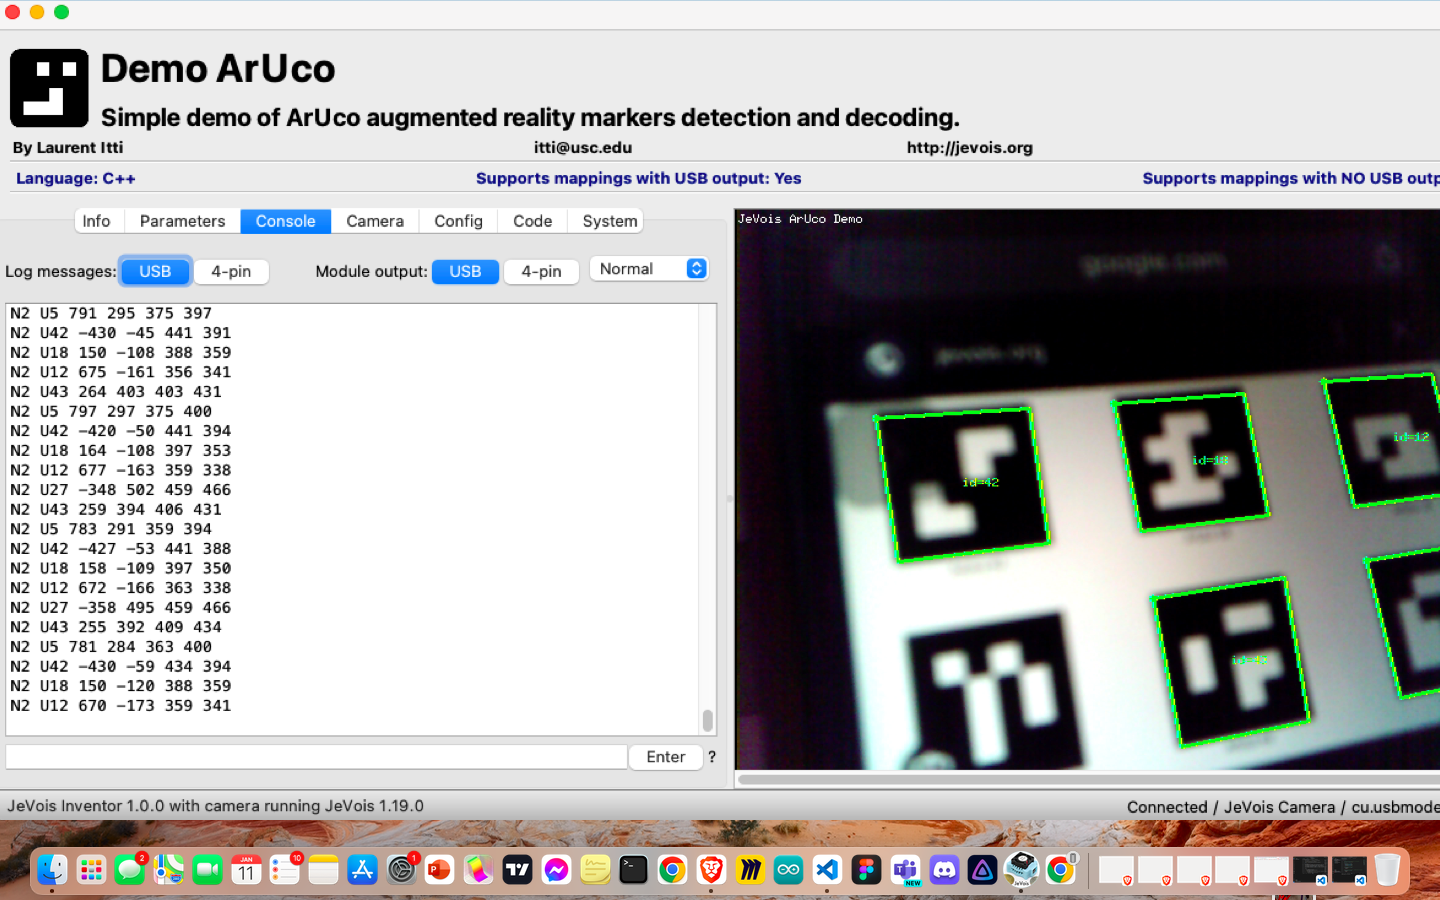

In [ ]:
#Arduino Uno TryOut


#//////// UltraSONIC and JEVOIS SERIAL ///////////


#include <PID_v1.h>

// Motor control pins
const int motor1pin1 = 2;
const int motor1pin2 = 3;
const int motor2pin1 = 4;
const int motor2pin2 = 5;

// Ultrasonic sensor pins
const int trigPin = 6;  // Example pin number
const int echoPin = 7;  // Example pin number
const long maxDistance = 100; // Example maximum distance for obstacle detection

// PID variables for marker tracking
double setPoint, input, output;
PID myPID(&input, &output, &setPoint, 2.0, 0.5, 1.0, DIRECT);

// Define the desired target width (distance to the marker)
const int desiredWidth = 300; // Adjust this based on your requirement

void setup() {
  pinMode(motor1pin1, OUTPUT);
  pinMode(motor1pin2, OUTPUT);
  pinMode(motor2pin1, OUTPUT);
  pinMode(motor2pin2, OUTPUT);

  pinMode(trigPin, OUTPUT);
  pinMode(echoPin, INPUT);

  Serial.begin(9600);

  // Initialize PID controller
  setPoint = 0; // Adjust setPoint as needed
  myPID.SetMode(AUTOMATIC);
  myPID.SetOutputLimits(-255, 255); // Set limits according to your motor's speed
}

void loop() {
  if (Serial.available() > 0) {
    String data = Serial.readStringUntil('\n');
    int id, x, y, width, height;
    if (sscanf(data.c_str(), "N2 %d %d %d %d %d", &id, &x, &y, &width, &height) == 5) {
      Serial.println("Marker detected.");
      input = desiredWidth - width; // Calculate the difference from the desired width
      myPID.Compute();
      moveRobot(output, x);
    } else {
      Serial.println("No marker detected.");
      if(checkForObstacle() == false) {
        moveForward();
      } else {
        stopMoving();
        turnLeft90();
        if(checkForObstacle() == true) {
          turnRight180();
          if(checkForObstacle() == true) {
            turnLeft360();  // Spin 360 degrees
            if(checkForObstacle() == true){
              moveBackward();
            }
          }
        }
      }
      delay(50); // Add a minor delay to prevent overloading the processor with rapid state changes
    }
  }
}

void moveRobot(double speed, int x) {
  if (speed > 0) {
    Serial.println("Moving backward.");
    moveBackward();
  } else if (speed < 0) {
    Serial.println("Moving forward.");
    moveForward();
  }
}

bool checkForObstacle() {
  digitalWrite(trigPin, LOW);
  delayMicroseconds(2);
  digitalWrite(trigPin, HIGH);
  delayMicroseconds(10);
  digitalWrite(trigPin, LOW);
  long duration = pulseIn(echoPin, HIGH);
  long distance = (duration / 2) / 29.1;
  return (distance < maxDistance && distance > 0);
}

void moveForward() {
  digitalWrite(motor1pin1, LOW);
  digitalWrite(motor1pin2, HIGH);
  digitalWrite(motor2pin1, LOW);
  digitalWrite(motor2pin2, HIGH);
}

void stopMoving() {
  digitalWrite(motor1pin1, LOW);
  digitalWrite(motor1pin2, LOW);
  digitalWrite(motor2pin1, LOW);
  digitalWrite(motor2pin2, LOW);
}

void turnLeft90() {
  stopMoving();
  delay(250); // A small delay to ensure the car stops before turning
  digitalWrite(motor1pin1, HIGH);
  digitalWrite(motor1pin2, LOW);
  digitalWrite(motor2pin1, LOW);
  digitalWrite(motor2pin2, HIGH);
  delay(1000);
  stopMoving();
}

void turnRight180() {
  stopMoving();
  delay(250);
  digitalWrite(motor1pin1, LOW);
  digitalWrite(motor1pin2, HIGH);
  digitalWrite(motor2pin1, HIGH);
  digitalWrite(motor2pin2, LOW);
  delay(2000);
  stopMoving();
}

void turnLeft360() {
  stopMoving();
  delay(250);
  digitalWrite(motor1pin1, HIGH);
  digitalWrite(motor1pin2, LOW);
  digitalWrite(motor2pin1, LOW);
  digitalWrite(motor2pin2, HIGH);
  delay(4000);
  stopMoving();
}

void moveBackward() {
  digitalWrite(motor1pin1, HIGH);
  digitalWrite(motor1pin2, LOW);
  digitalWrite(motor2pin1, HIGH);
  digitalWrite(motor2pin2, LOW);
  delay(2000);
  stopMoving();
}

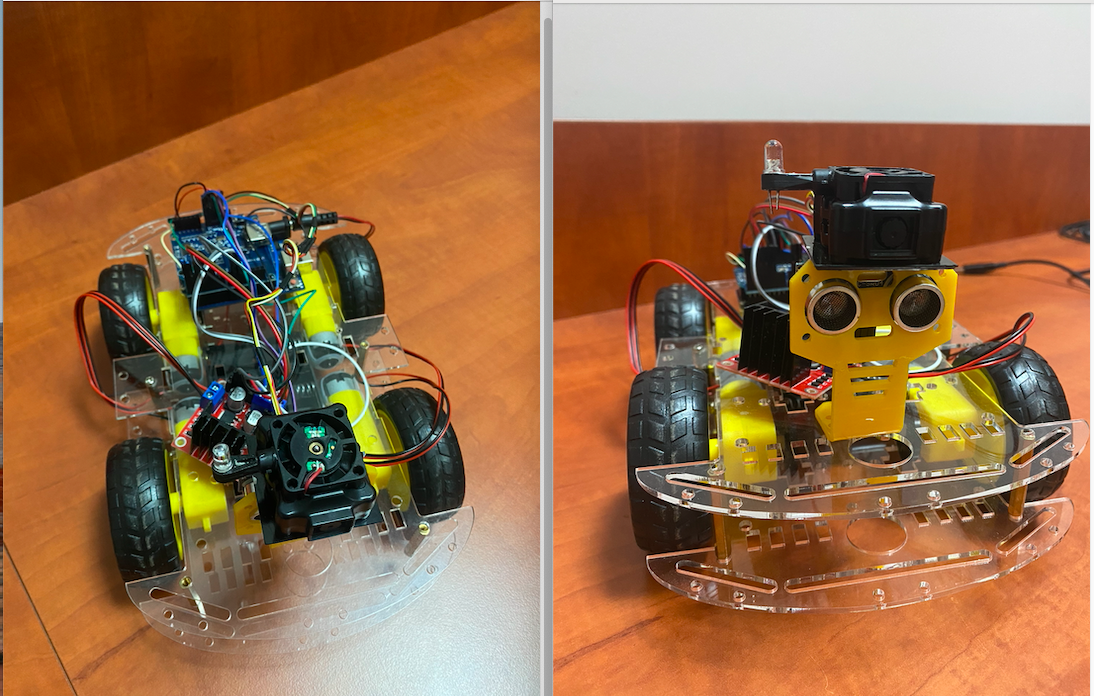

2. Raspberry Pi Configuration Connect JeVois to Raspberry Pi: Use a USB cable or Serial connector to connect the JeVois camera to the Raspberry Pi. Ensure the camera is set to the correct mode to output serial data over USB.

In [ ]:
import serial

serdev = '/dev/tty.usbmodem14203'
#serdev = '/dev/ttyACM0' # serial device of JeVois on Linux

with serial.Serial(serdev, 115200, timeout=2) as ser:
    while 1:
        # Read a whole line and strip any trailing line ending character:
        line = ser.readline().rstrip()
        print("received: {}".format(line))
        print(f"Line {line}")
        # Split the line into tokens:
        tok = line.split()

        # Skip if timeout or malformed line:
        if len(tok) < 1: continue

        if tok[0] != 'N2': continue

        # From now on, we hence expect: N2 id x y w h
        if len(tok) != 6: continue

        # Assign some named Python variables to the tokens:
        key, id, x, y, w, h = tok

        print("Found ArUco {} at ({},{}) size {}x{}".format(id, x, y, w, h))



# #ls /dev/tty.*   to find correct port name
# # setpar serout USB
# # setpar serlog USB
# #setpar serstyle Normal
"""On Linux: /dev/ttyACM0
On Mac: /dev/tty.usbmodem*
On WIndows: COM3:"""


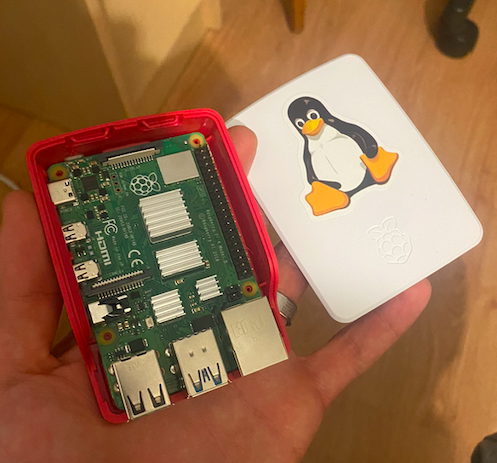

#Raspberry Pi ArUco
Serial Port Configuration: Ensure that the Raspberry Pi’s serial port is correctly configured and accessible. You might need to adjust the Raspberry Pi configuration (using raspi-config) to enable the serial port and disable the login shell over serial.
- Install Serial Library: Install pyserial on Raspberry Pi for serial communication using pip install pyserial.

3. Python Script for Serial Communication Write a Python Script: Use Python script to read and decode serial data from the JeVois camera. This script will handle communication between the JeVois camera and the Raspberry Pi.

In [ ]:
import cv2
import serial
import time

# Set up serial connection (adjust port and baudrate according to your configuration)help
port = '/dev/tty.usbmodem14203'  # replace with your JeVois serial port
baudrate = 115200
ser = serial.Serial(port, baudrate, timeout=1)

time.sleep(2)  # Wait for the connection to establish

# Function to send commands to JeVois
def send_command(command):
    ser.write('{}\n'.format(command).encode('utf-8'))
    time.sleep(0.1)  # Wait for the command to be processed
    while ser.in_waiting:
        print(ser.readline().decode('utf-8').rstrip())

# Send command to load the ArUco module
send_command('setmapping2 YUYV 320 240 30.0 JeVois DemoArUco')

# Initialize video capture from JeVois camera
# The camera index (e.g., 0, 1) depends on how many cameras are connected
# and may vary. You might need to experiment to find the right index.
cap = cv2.VideoCapture(0)  #0 for intro all in one; 8 for ArUco

# Set the resolution to 640x480
desired_width = 640
desired_height = 480
cap.set(cv2.CAP_PROP_FRAME_WIDTH, desired_width)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, desired_height)

try:
    while True:
        # Capture frame-by-frame from JeVois
        ret, frame = cap.read()
        if ret:

            # Flip frame
            frame = cv2.flip(frame, 1)  # Flip both horizontally and vertically with -1

            # Display the resulting frame
            cv2.imshow('JeVois Camera Feed', frame)

            # Exit on pressing the 'q' key
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        # Read from serial port
        if ser.in_waiting:
            line = ser.readline().decode('utf-8').rstrip()
            print(f"Received: {line}")
except:
    print("can't grab frame \n")
    print(Exception)

finally:
    # When everything is done, release the capture and close serial port
    cap.release()
    cv2.destroyAllWindows()
    ser.close()




"""Output:
Received: T2 -106 156
Received: T2 -94 150
Received: T2 -63 156
Received: T2 -100 181
Received: T2 -81 181
Received: T2 -100 194
Received: T2 -119 162
Received: T2 -69 162
Received: T2 -56 156
Received: T2 -44 144
Received: T2 -88 175
Received: INF JeVoisIntro::process: Object recognition: best: 2 (98.89), second best: 1 (8.68585)

Use data for location tracking and motors manipulation
Change width and height / resolution according to your module


"""

Run and Test: Run the script and ensure it correctly reads and prints the marker data received from the JeVois camera to the Pi.

4. Flask Server Setup Install Flask and Dependencies: Install Flask and related libraries on the Raspberry Pi with pip install Flask paramiko. (websocket if needed)
- Write a Flask Server Script: This server will handle HTTP requests and can send commands to the Raspberry Pi via SSH on localhost pi@raspberrypi.local [port 22].
- Run the Flask Server: Start the Flask server and ensure it's accessible from your network.


In [ ]:
from flask import Flask, jsonify, request
from flask_cors import CORS
import paramiko

app = Flask(__name__)
CORS(app)

def ssh_execute_command(command):
    ssh = paramiko.SSHClient()
    ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    ssh.connect("raspberrypi.local", port=22, username="pi", password="pass")

    stdin, stdout, stderr = ssh.exec_command(command)
    output = stdout.read().decode()

    ssh.close()
    return output

@app.route('/start_mission', methods=['POST'])
#example mission over the wifi network to display a message on the Pi Desktop
def start_mission():
    command = "DISPLAY=:0 xmessage 'Hello from the GCS' "
    # Implement the JEVOIS commands here

    try:
        print("STARTING MISSION")
        # Replace 'ls' with your actual command to start the drone mission
        output = ssh_execute_command(command)
        return jsonify({'status': 'Mission successfully started', 'output': output}), 200
    except Exception as e:
        return jsonify({'status': 'Error', 'error': str(e)}), 500

@app.route('/home')
def home():
    return jsonify(message="Hello World! Welcome to my post requests pi communication server")

if __name__ == '__main__':
    app.run(debug=True)


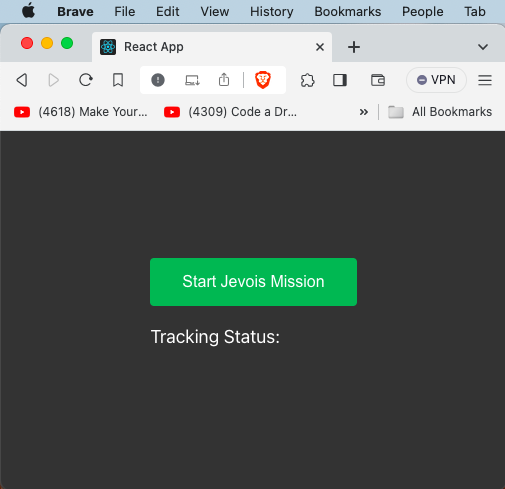

5. React Frontend Application Set Up React Environment: Make sure Node.js and npm are installed on your development machine. Create a new React app with npx create-react app newapp.
- Write React Code: Implement the frontend using React. Install axios for making HTTP requests with npm.
- Run and Test: Start the React app and test the connection to the Flask server. Ensure the button triggers the start of the mission and that the status is correctly displayed.

In [ ]:
// npm install socket.io-client or with requests
//or npm install axios


import React, { useState } from 'react';
import axios from 'axios';

const SERVER_URL = "http://localhost:5000";

const App = () => {
    const [missionStatus, setMissionStatus] = useState('');

    const startJevoisMission = () => {
        axios.post(`${SERVER_URL}/start_mission`)
            .then(response => {
                setMissionStatus(response.data.status + " - " + response.data.output);
            })
            .catch(error => {
                setMissionStatus('Error starting mission: ' + error.message);
            });
    };

    return (
        <div>
            <button onClick={startJevoisMission}>Start Jevois Mission</button>
            <p>Mission Status: {Tracking Status}</p>
        </div>
    );
};

export default App;

6. Testing and Debugging End-to-End Testing: Test the entire setup together. Ensure that the JeVois camera correctly sends marker data, the Raspberry Pi reads this data, and the React app can initiate actions and receive status updates.
- Debug as Needed: Use console logs, print statements, and network inspection tools to debug any issues that arise.
- Finalize the React App: Deploy the React App on the web with Firebase and handle remote connections.

Additional Considerations
-	Power Supply: Ensure the JeVois camera and Raspberry Pi have a stable power supply. Make sure the 5V to the jevois doesn’t drain the voltage to the Pi.
-	Network Configuration: If the React app and Flask server are on different networks, ensure proper network configuration  with CORS and port forwarding.
-	Keep in mind that ready to go C++ modules don’t go well with the Arduino Uno environment over USB (because of usb shield library availability and bit signals not being decoded properly [serial connection needed])
-	I choose to do all in one – in Pi & Python code for transparency and compatibility